In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

Welcome to JupyROOT 6.12/04


In [5]:
# import data from 60 hr trolley run and fixed probe run

filename = 'hdf5/60hr.h5'

tr_interp_df_1 = pd.read_hdf(filename, key='tr_df_1')
fp_interp_df_1 = pd.read_hdf(filename, key='fp_df_1')
tr_interp_df_2 = pd.read_hdf(filename, key='tr_df_2')

tr_moment_df_1 = helper.calc_moment_df(tr_interp_df_1)
tr_moment_df_2 = helper.calc_moment_df(tr_interp_df_2)
fp_moment_df_1 = helper.calc_moment_df(fp_interp_df_1)

Finished calculating all moments for 4386 events.
Finished calculating all moments for 4363 events.
Finished calculating all moments for 257281 events.  


In [147]:
# look at length of tr runs, pick random starting point in fixed probe run to call fake trolley

## trolley moment dfs are 4300-4400 seconds long

duration = np.random.randint(4300,4401)
start = np.random.randint(0, fp_moment_df_1.shape[0]-duration)

fake_tr_run = fp_moment_df_1.iloc[start:start+duration].copy()

In [148]:
# trolley runs start at 262.2 deg and end at 262.7 deg

tr_phi = (np.linspace(262.2, 262.7+360, duration) + np.random.uniform(-0.03,0.03,))%360
fake_tr_run['tr_phi'] = tr_phi

In [149]:
no_mask_df = fake_tr_run.copy()
t0 = no_mask_df.index.values[0]
no_mask_df.index -= t0
index = no_mask_df.index.values

veto_extent = 25

for st in [20]:  # range(72):
    print '\rRemoving trolley image from station '+str(st)+'.',

    # veto when trolley is close to station

    veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
    veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
    if veto_low < veto_high:
        veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
    else:  # this happens when wrapping around 360 deg
        veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

    for m in [0]:  #range(6):

        stm = 'st'+str(st)+',m'+str(m+1)

        # calculate local drift

        times = no_mask_df.index.values[~veto_mask]
        freqs = no_mask_df[stm][~veto_mask]

        local_drift_fit = np.polyfit(times, freqs, 5)
        local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

        # need to average other side of ring
        all_good_stations = np.arange(6,72)  # not using the inflector stations
        no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

        # next need to average all good stations that are not within 3 of current station
        if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
            averaging_stations = np.delete(all_good_stations,
                                           np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                                      | (np.abs((all_good_stations - st)%72)>=69))
                                          )
        else:
            averaging_stations = np.delete(no_ground_loop_stations,
                                           np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                                      | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                          )
        avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
        replacement = no_mask_df[avg_stms].mean(axis=1)

        # calculate global drift
        global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
        global_drift = np.polyval(global_drift_fit, index[veto_mask])

        # subtract global drift from replacement
        replacement = replacement[veto_mask] - global_drift

        # add local drift
        replacement = replacement + local_drift[veto_mask]

        no_mask_df[stm][veto_mask] = replacement

no_mask_df.index += t0

Removing trolley image from station 20.


In [150]:
if veto_low < veto_high:
    veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
else:  # this happens when wrapping around 360 deg
    veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

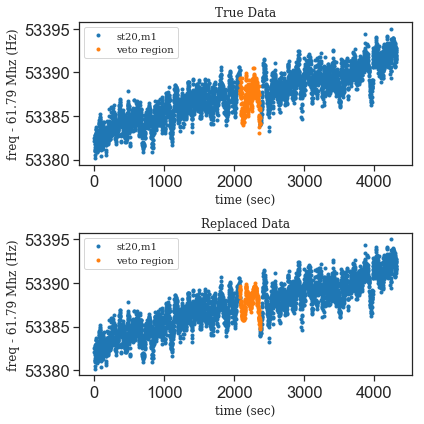

In [160]:
fig1, ax1 = plt.subplots(2,1)

ax1[0].plot(fake_tr_run.index.values[~veto_mask]-t0, fake_tr_run['st20,m1'][~veto_mask], '.')
ax1[0].plot(fake_tr_run.index.values[veto_mask]-t0, fake_tr_run['st20,m1'][veto_mask], '.', label='veto region')
ax1[1].plot(no_mask_df.index.values[~veto_mask]-t0, no_mask_df['st20,m1'][~veto_mask], '.')
ax1[1].plot(no_mask_df.index.values[veto_mask]-t0, no_mask_df['st20,m1'][veto_mask], '.', label='veto region')

for ax in ax1:
    ax.set_xlabel('time (sec)', fontdict={'size':12, 'family':'serif'})
    ax.set_ylabel('freq - 61.79 Mhz (Hz)', fontdict={'size':12, 'family':'serif'})
    ax.legend(prop={'size':10, 'family':'serif'})

ax1[0].set_title('True Data', fontdict={'size':12, 'family':'serif'})
ax1[1].set_title('Replaced Data', fontdict={'size':12, 'family':'serif'})

fig1.set_size_inches(6,6)
fig1.tight_layout()

fig1.savefig('replacement_syst_demo.png', dpi=300)

In [145]:
plt2.plt_unix_time_to_CST(ax1[0])

In [60]:
## find averages

def trolley_run_station_average(corrected_df):
        
    station_edges = trfp.STATION_BARCODE_EDGES
    station_edges_6_probe = trfp.STATION_BARCODE_EDGES_6

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.full((72,6), np.nan)
    fp_baseline = np.full((72,6), np.nan)
    summed_azimuth = np.full((72,6), np.nan)
    summed_pts = np.full((72,6), np.nan)
    baseline_time = np.full((72,6), np.nan)

    st6 = 0
    for st in range(72):
        
        num_probes = len(trfp.STATION_PROBE_ID[st])
        # first do m1-4 for all stations
        
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask].copy()
        summed_pts[st, :] = out_df.shape[0]
        summed_azimuth[st, :] = sum(out_df['tr_extent'].values)
        baseline_time[st, :] = sum(out_df.index.values)/summed_pts[st, 0]

        for m in range(6):

            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
                
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts

In [62]:
_, fake_fp_baseline, _, _, _ = trolley_run_station_average(no_mask_df)
_, real_fp_baseline, _, _, _ = trolley_run_station_average(fake_tr_run)

In [66]:
print fake_fp_baseline.shape

(72, 6)


In [63]:
print fake_fp_baseline[20,0]
print real_fp_baseline[20,0]

53476.68741702187
53476.40665143994


In [64]:
## automate the above and compare all stations many time to histogram the uncertainty

def footprint_replacment(fake_tr_run):
    no_mask_df = fake_tr_run.copy()
    t0 = no_mask_df.index.values[0]
    no_mask_df.index -= t0
    index = no_mask_df.index.values

    veto_extent = 25

    for st in range(72):
        print '\rRemoving trolley image from station '+str(st)+'.',

        # veto when trolley is close to station

        veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
        veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
        if veto_low < veto_high:
            veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
        else:  # this happens when wrapping around 360 deg
            veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

        for m in range(6):

            stm = 'st'+str(st)+',m'+str(m+1)

            # calculate local drift

            times = no_mask_df.index.values[~veto_mask]
            freqs = no_mask_df[stm][~veto_mask]

            local_drift_fit = np.polyfit(times, freqs, 5)
            local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

            # need to average other side of ring
            all_good_stations = np.arange(6,72)  # not using the inflector stations
            no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

            # next need to average all good stations that are not within 3 of current station
            if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
                averaging_stations = np.delete(all_good_stations,
                                               np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                                          | (np.abs((all_good_stations - st)%72)>=69))
                                              )
            else:
                averaging_stations = np.delete(no_ground_loop_stations,
                                               np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                                          | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                              )
            avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
            replacement = no_mask_df[avg_stms].mean(axis=1)

            # calculate global drift
            global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
            global_drift = np.polyval(global_drift_fit, index[veto_mask])

            # subtract global drift from replacement
            replacement = replacement[veto_mask] - global_drift

            # add local drift
            replacement = replacement + local_drift[veto_mask]

            no_mask_df[stm][veto_mask] = replacement

    no_mask_df.index += t0
    return no_mask_df

In [84]:
## in for loop, generate fake data set, average the replacement data and real data, and look at difference

N = 50

m_diffs = np.empty([72,6,N])

for ii in range(N):
    
    print ii
    
    duration = np.random.randint(4300,4401)
    start = np.random.randint(0, fp_moment_df_1.shape[0]-duration)
    fake_tr_run = fp_moment_df_1.iloc[start:start+duration].copy()
    tr_phi = (np.linspace(262.2, 262.7+360, duration) + np.random.uniform(-0.03,0.03,))%360
    fake_tr_run['tr_phi'] = tr_phi
    
    fake_replaced = footprint_replacment(fake_tr_run)
    
    _, replaced_fp_baseline, _, _, _ = trolley_run_station_average(fake_replaced)
    _, real_fp_baseline, _, _, _ = trolley_run_station_average(fake_tr_run)
    
    m_diffs[:,:,ii] = replaced_fp_baseline - real_fp_baseline

0
Removing trolley image from station 71.            1
Removing trolley image from station 71.             2
Removing trolley image from station 71.             3
Removing trolley image from station 71.             4
Removing trolley image from station 71.             5
Removing trolley image from station 71.             6
Removing trolley image from station 71.             7
Removing trolley image from station 71.             8
Removing trolley image from station 71.              9
Removing trolley image from station 71.             10
Removing trolley image from station 71.              11
Removing trolley image from station 71.             12
Removing trolley image from station 71.             13
Removing trolley image from station 71.             14
Removing trolley image from station 71.             15
Removing trolley image from station 71.             16
Removing trolley image from station 71.             17
Removing trolley image from station 71.              18
Removing trolle

[ 3.77118157e+02 -3.10269637e-05  4.82843976e-01]


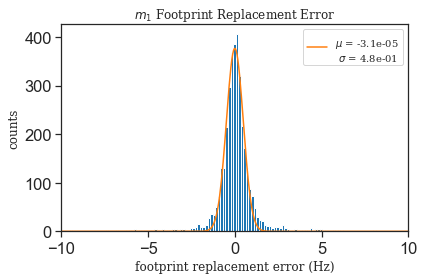

In [161]:
m1_diffs = m_diffs[:,0,:].flatten()

def gaussian(x, A, x0, s): return A * np.exp(-(x-x0)**2/(2*s**2))

fig2, ax2 = plt.subplots(1,1)

out = ax2.hist(m1_diffs, bins=500)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2

fit, _ = curve_fit(gaussian, bins, counts)

ax2.plot(np.linspace(-25,25,1000), gaussian(np.linspace(-25,25,1000), *fit),
         label=('$\mu$ = %.1e \n $\sigma$ = %.1e'%(fit[1],fit[2])))
ax2.set_xlim(-10,10)
ax2.legend(prop={'size':10, 'family':'serif'})

ax2.set_title('$m_1$ Footprint Replacement Error', fontdict={'size':12, 'family':'serif'})
ax2.set_xlabel('footprint replacement error (Hz)', fontdict={'size':12, 'family':'serif'})
ax2.set_ylabel('counts', fontdict={'size':12, 'family':'serif'})

fig2.set_size_inches(6,4)
fig2.tight_layout()

print fit

fig2.savefig('replacement_m1_hist.png', dpi=300)


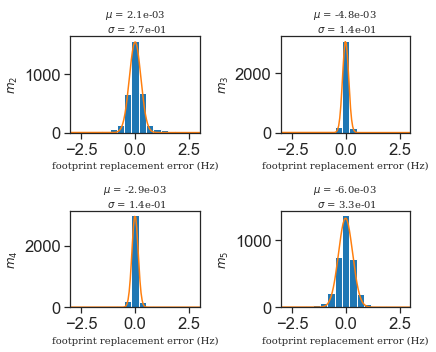

In [166]:
fig3, ax3 = plt.subplots(2,2)

for i in range(2):
    for j in range(2):
        m = 2*i + j
        diffs = m_diffs[:,m+1,:].flatten()
        
        out = ax3[i,j].hist(diffs, bins=np.linspace(-10,10, 60))
        counts = out[0]
        bins = (out[1][1:]+out[1][:-1])/2

        fit, _ = curve_fit(gaussian, bins, counts)

        ax3[i,j].plot(np.linspace(-25,25,1000), gaussian(np.linspace(-25,25,1000), *fit))
        ax3[i,j].set_title(('$\mu$ = %.1e \n $\sigma$ = %.1e'%(fit[1],np.abs(fit[2]))), fontdict={'size':10, 'family':'serif'})
        ax3[i,j].set_xlim(-3,3)
        ax3[i,j].set_xlabel('footprint replacement error (Hz)', fontdict={'size':10, 'family':'serif'})
        ax3[i,j].set_ylabel('$m_'+str(m+2)+'$', fontdict={'size':12, 'family':'serif'})

fig3.set_size_inches(6,5)
fig3.tight_layout()

fig3.savefig('replacement_m2-5_hist.png', dpi=300)

In [100]:
diffs = m_diffs[:,1,:].flatten()

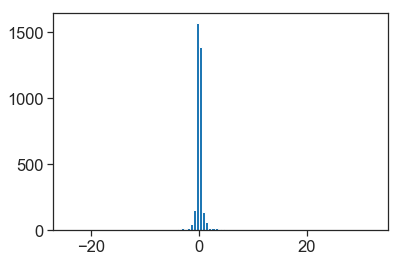

In [107]:
out = plt.hist(diffs, bins=100)